<a href="https://colab.research.google.com/github/lddm/ml-journey/blob/main/Planet_Amazon_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# License: BSD
# Author: Sasank Chilamkurthy

%matplotlib inline

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from PIL import Image
import cv2
from sklearn.preprocessing import MultiLabelBinarizer

ROOT_PATH = '/content/gdrive/MyDrive/planet_amazon'
MODEL_PATH = os.path.join(ROOT_PATH, 'planet_challenge_model.pt')

plt.ion()   # interactive mode
os.chdir(ROOT_PATH)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Uncompress data

In [ ]:
# root_path = '/content/gdrive/MyDrive/planet_amazon'
# import os
# os.getcwd()
# os.chdir(root_path)  #change dir
# !mkdir train  #create a directory named train/
# !mkdir test  #create a directory named test/
# !tar -xvf  'train-jpg.tar' -C 'train'
# !tar -xvf  'test-jpg.tar' -C 'test'

# Auxiliary functions

In [52]:
def get_items(df):
    return df
    # Grab subset of items
    # return df.sample(n=64*30, random_state=891237)

def get_x(df_row):
    img_name = df_row['image_name']
    img_path = os.path.join(TRAIN_DIR, f'{img_name}.jpg')
    return img_path

def get_y(df_row):
    return df_row['tags'].split(' ')

def imshow(inp, fig_size=4, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Access data

In [67]:
TRAIN_DIR = 'train/train-jpg'
TEST_DIR = 'test/test-jpg'
data_dirs = {
    'train': TRAIN_DIR
}
# print('Train dataset size: ', len([name for name in os.listdir(TRAIN_DIR) if os.path.isfile(os.path.join(TRAIN_DIR, name))]))
# print('Test dataset size: ', len([name for name in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, name))]))

In [ ]:
train_df = pd.read_csv('train_v2.csv')
train_img_path = get_x(train_df.loc[0])
print(train_img_path)
tags = get_y(train_df.loc[0])
print(tags)

train_img = cv2.imread(train_img_path)
train_img.shape

train/train-jpg/train_0.jpg
['haze', 'primary']


(256, 256, 3)

### Handle dataset particular structure

The [torchvision.datasets](https://pytorch.org/vision/0.8/datasets.html#torchvision-datasets) class expects a specific structure for the data and their corresponding labels, e.g: 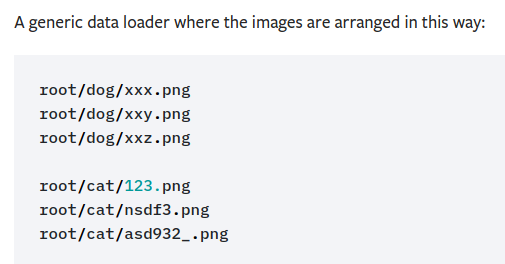

This is not very convenient for handling how data is provided in the Kaggle _Understanding the Amazon from Space_ challenge. This is easily fixable by implementing a custom sub-class of the torch Dataset class. Code below is based on https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning#Loading-the-data---first-part---DataSet  

The implemented `KaggleAmazonDataset` makes use of [sklearn.preprocessing.MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn-preprocessing-multilabelbinarizer) to encode the categorical labels in a convenient numerical format for the training.

In [16]:
class KaggleAmazonDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle - Planet Amazon from Space competition.

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        Transform (optional) object containing transformations to apply on imagery.
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None, number_samples=None):
    
        self.tmp_df = pd.read_csv(csv_path)
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform
        
        self._check_corrupt_files()

        image_names = self.tmp_df['image_name']
        tags = self.tmp_df['tags']
        if number_samples:
          image_names = image_names[:number_samples]
          tags = tags[:number_samples]
          self.dataset_size = number_samples
        else:
          self.dataset_size = len(image_names)

        self.X_train = image_names
        # self.y_train is a sparse-matrix of size num_samples x num_classes where an element [i,j] equals 1 
        # iff the sample with index 'i' correspond to class 'j'
        self.y_train = self.mlb.fit_transform(tags.str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.X_train[index] + 
                                      self.img_ext))
        img = img.convert('RGB')
        if self.transform is not None:
          img = self.transform(img)

        label = torch.from_numpy(self.y_train[index])
        return img, label
    
    def _check_corrupt_files(self):
        # check that all images listed in the train.csv are available on the training folder
        assert self.tmp_df['image_name'].apply(lambda x: os.path.isfile(os.path.join(
                self.img_path, x + self.img_ext))).all(), \
"Some images referenced in the CSV file were not found"
        
        # some files available in the folder are corrupted causing an PIL.UnidentifiedImageError
        for image_name in self.tmp_df['image_name']:
          file_size = os.stat(os.path.join(
              self.img_path, image_name + self.img_ext)).st_size
          if file_size == 0:
            raise(OSError('File {} is corrupt'.format(image_name)))
        
    
    def decode_binary_label(self, array):
      return self.mlb.inverse_transform(array)

    def __len__(self):
        return len(self.X_train.index)

## Load training data

In [18]:
# the parameters used here are based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


data_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      # Normalization mean and std. dev. 
                                      # factors are taken from ImageNet
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])])

train_dataset = KaggleAmazonDataset('train_v2.csv', TRAIN_DIR, '.jpg', 
                                    data_transforms)

train_loader = DataLoader(train_dataset,
                          batch_size=125,
                          shuffle=True,
                          num_workers=1, # 1 for CUDA
                          pin_memory=True # CUDA only
                         )

dataset_sizes = {'train': train_dataset.dataset_size}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

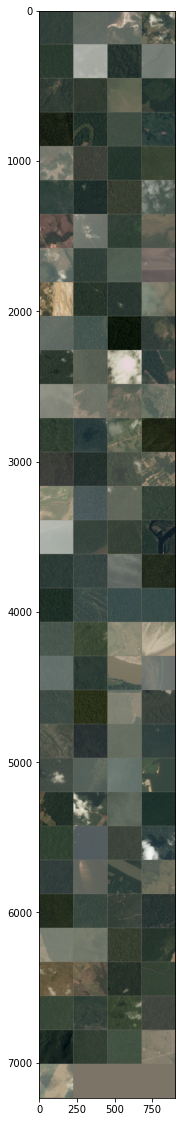

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out, fig_size=20)

In [ ]:
train_dataset.decode_binary_label(classes)
# classes[0]

[('clear', 'primary'),
 ('haze', 'primary'),
 ('bare_ground', 'clear', 'primary', 'road', 'water'),
 ('agriculture', 'partly_cloudy', 'primary'),
 ('clear', 'primary'),
 ('cloudy',),
 ('clear', 'primary'),
 ('haze', 'primary', 'water'),
 ('agriculture', 'clear', 'cultivation', 'primary'),
 ('clear', 'primary'),
 ('agriculture', 'clear', 'primary'),
 ('bare_ground', 'clear', 'habitation', 'primary', 'water'),
 ('clear', 'primary'),
 ('agriculture', 'clear', 'cultivation', 'primary'),
 ('clear', 'primary'),
 ('clear', 'cultivation', 'primary', 'water'),
 ('agriculture', 'clear', 'primary', 'water'),
 ('clear', 'primary', 'road', 'selective_logging'),
 ('clear', 'primary'),
 ('clear', 'primary'),
 ('clear', 'primary', 'slash_burn'),
 ('partly_cloudy', 'primary'),
 ('clear', 'primary', 'water'),
 ('partly_cloudy', 'primary'),
 ('agriculture', 'clear', 'primary', 'water'),
 ('partly_cloudy', 'primary', 'road', 'water'),
 ('clear', 'primary'),
 ('bare_ground', 'clear', 'primary'),
 ('agricul

# Train model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, save_model=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs > 0 
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_model:
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': epoch_loss,
                      'accuracy': epoch_acc
                      }, MODEL_PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Finetunning the convnet

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
num_classes = len(train_dataset.mlb.classes_)
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()
# Loss selected for multi-label classification problem based on https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/45
criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-3, weight_decay=5e-7)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
load_model = False
if load_model:
  checkpoint = torch.load(MODEL_PATH)
  model_ft.load_state_dict(checkpoint['model_state_dict'])
  optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=30, save_model=True)

Epoch 0/29
----------
train Loss: 0.1281 Acc: 16.1763

Epoch 1/29
----------
train Loss: 0.1078 Acc: 16.3096

Epoch 2/29
----------
train Loss: 0.1012 Acc: 16.3527

Epoch 3/29
----------
train Loss: 0.0968 Acc: 16.3781

Epoch 4/29
----------
train Loss: 0.0924 Acc: 16.4089

Epoch 5/29
----------
train Loss: 0.0891 Acc: 16.4241

Epoch 6/29
----------
train Loss: 0.0855 Acc: 16.4480

Epoch 7/29
----------
train Loss: 0.0677 Acc: 16.5677

Epoch 8/29
----------
train Loss: 0.0589 Acc: 16.6243

Epoch 9/29
----------
train Loss: 0.0516 Acc: 16.6736

Epoch 10/29
----------
train Loss: 0.0429 Acc: 16.7382

Epoch 11/29
----------
train Loss: 0.0338 Acc: 16.8017

Epoch 12/29
----------
train Loss: 0.0256 Acc: 16.8576

Epoch 13/29
----------
train Loss: 0.0190 Acc: 16.8980

Epoch 14/29
----------
train Loss: 0.0136 Acc: 16.9308

Epoch 15/29
----------
train Loss: 0.0121 Acc: 16.9406

Epoch 16/29
----------
train Loss: 0.0114 Acc: 16.9429

Epoch 17/29
----------
train Loss: 0.0105 Acc: 16.9498

Ep

# Visualize model

In [42]:
def load_test_image(img_path, transform=None):
    img = Image.open(img_path)
    img = img.convert('RGB')
    if transform is not None:
      img = transform(img)

    img = img.unsqueeze(0)

    return img

In [64]:
def visualize_model(model, image, multi_label_binarizer):
    was_training = model.training
    model.eval()
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
      inputs = image.to(device)
      outputs = model(inputs)
      preds = outputs > 0
      print('Labels: ', multi_label_binarizer.inverse_transform(preds.cpu()))
      imshow(inputs.squeeze(0).cpu().data)
    
    model.train(mode=was_training)

In [25]:
model = models.resnet50()
num_ftrs = model.fc.in_features
num_classes = len(train_dataset.mlb.classes_)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [61]:
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Labels:  [('clear', 'primary')]


<Figure size 720x720 with 0 Axes>

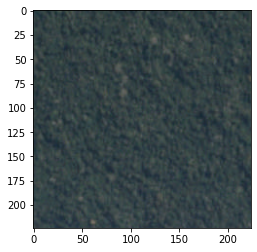

Labels:  [('agriculture', 'clear', 'habitation', 'primary', 'road')]


<Figure size 720x720 with 0 Axes>

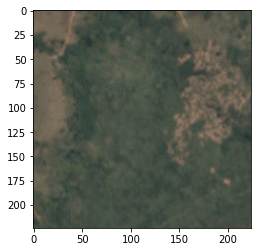

Labels:  [('agriculture', 'partly_cloudy', 'primary')]


<Figure size 720x720 with 0 Axes>

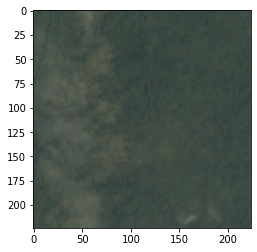

Labels:  [('clear', 'primary')]


<Figure size 720x720 with 0 Axes>

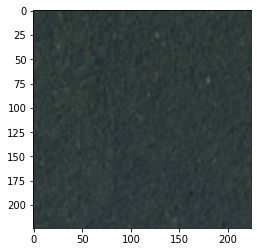

Labels:  [('agriculture', 'clear', 'primary', 'road')]


<Figure size 720x720 with 0 Axes>

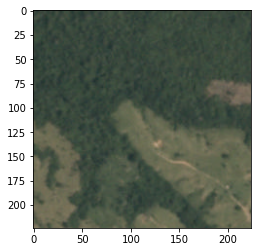

Labels:  [('haze', 'primary')]


<Figure size 720x720 with 0 Axes>

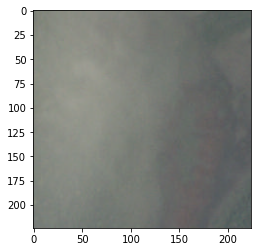

Labels:  [('primary',)]


<Figure size 720x720 with 0 Axes>

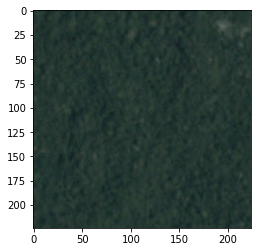

Labels:  [('clear', 'habitation', 'road')]


<Figure size 720x720 with 0 Axes>

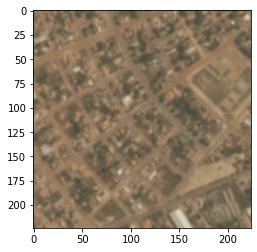

Labels:  [('clear', 'primary')]


<Figure size 720x720 with 0 Axes>

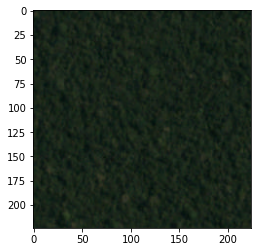

Labels:  [('partly_cloudy', 'primary')]


<Figure size 720x720 with 0 Axes>

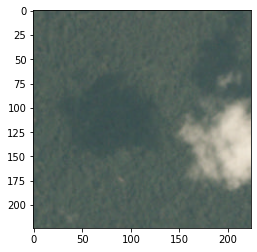

In [70]:
TEST_DIR = 'test/test-jpg'
for image_name in os.listdir(TEST_DIR)[10:20]:
  test_im_path = os.path.join(TEST_DIR, image_name)
  test_im = load_test_image(test_im_path, test_transforms)
  visualize_model(model, test_im, train_dataset.mlb)
